In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, models, transforms
from torch.utils.data import DataLoader, Subset
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import random
import time
import copy

# 1. CẤU HÌNH CƠ BẢN
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"✅ Đang sử dụng thiết bị: {device}")

def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True

set_seed(42)

# Đường dẫn đến bộ dữ liệu mới cân bằng
DATA_DIR = 'LongAn_Binary_Dataset_1k' # Sửa lại đường dẫn nếu chạy trên local

# 2. DATA AUGMENTATION (Tăng cường dữ liệu)
IMG_SIZE = 224
BATCH_SIZE = 32

data_transforms = {
    'train': transforms.Compose([
        # RandomResizedCrop: Ép model học cả cục bộ và toàn thể (Rất tốt cho Binary)
        # transforms.RandomResizedCrop(IMG_SIZE, scale=(0.7, 1.0)), 
        transforms.Resize((IMG_SIZE, IMG_SIZE)),
        transforms.RandomHorizontalFlip(),
        transforms.RandomVerticalFlip(),
        transforms.RandomRotation(15),
        transforms.ColorJitter(brightness=0.2, contrast=0.2),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize((IMG_SIZE, IMG_SIZE)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

# 3. LOAD DATASET & KIỂM TRA NHÃN
full_dataset = datasets.ImageFolder(DATA_DIR)
class_names = full_dataset.classes
print(f"📂 Các lớp tìm thấy: {class_names}")
print(f"🔢 Mapping: {full_dataset.class_to_idx}")
# Mong đợi: {'0_AnToan': 0, '1_NguyCo': 1}

# 4. CHIA TẬP DỮ LIỆU
# Giữ nguyên chiến thuật: Tách 20% làm Test set (Giấu đi hoàn toàn)
# 80% còn lại dùng cho Cross-Validation (Train/Val)
targets = [y for _, y in full_dataset.samples]

train_idx, test_idx = train_test_split(
    list(range(len(full_dataset))),
    test_size=0.2,
    stratify=targets,
    random_state=42
)

# Wrapper Dataset để áp dụng transform riêng biệt
class CustomSubset(torch.utils.data.Dataset):
    def __init__(self, subset, transform=None):
        self.subset = subset
        self.transform = transform
    def __getitem__(self, index):
        x, y = self.subset[index]
        if self.transform: x = self.transform(x)
        return x, y
    def __len__(self): return len(self.subset)

# Tạo Test Set chuẩn
test_subset = Subset(full_dataset, test_idx)
test_dataset = CustomSubset(test_subset, transform=data_transforms['val'])
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)

print(f"\n📊 THỐNG KÊ DỮ LIỆU:")
print(f"   - Tổng cộng: {len(full_dataset)} ảnh")
print(f"   - Train Set (cho CV): {len(train_idx)} ảnh")
print(f"   - Test Set (giấu đi): {len(test_idx)} ảnh")

✅ Đang sử dụng thiết bị: cuda
📂 Các lớp tìm thấy: ['0_AnToan', '1_NguyCo']
🔢 Mapping: {'0_AnToan': 0, '1_NguyCo': 1}

📊 THỐNG KÊ DỮ LIỆU:
   - Tổng cộng: 2000 ảnh
   - Train Set (cho CV): 1600 ảnh
   - Test Set (giấu đi): 400 ảnh


In [9]:
def train_model_v2(model, train_loader, val_loader, criterion, lr, weight_decay, epochs_freeze=5, epochs_unfreeze=15):
    total_epochs = epochs_freeze + epochs_unfreeze
    optimizer = optim.Adam(model.fc.parameters(), lr=lr, weight_decay=weight_decay)
    best_acc = 0.0
    
    # 1. Thêm biến này để lưu lịch sử
    history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}
    
    for epoch in range(total_epochs):
        # --- GIAI ĐOẠN 2: UNFREEZE ---
        if epoch == epochs_freeze:
            print(f"      >> [Info] Unfreeze & Giảm LR (Epoch {epoch+1})")
            for param in model.parameters():
                param.requires_grad = True
            optimizer = optim.Adam(model.parameters(), lr=lr * 0.1, weight_decay=weight_decay)

        epoch_metrics = {}

        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
                dataloader = train_loader
            else:
                model.eval()
                dataloader = val_loader

            running_loss = 0.0
            running_corrects = 0

            for inputs, labels in dataloader:
                inputs = inputs.to(device)
                labels = labels.to(device)
                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / len(dataloader.dataset)
            epoch_acc = running_corrects.double() / len(dataloader.dataset)
            epoch_acc_val = epoch_acc.item()
            
            epoch_metrics[f'{phase}_loss'] = epoch_loss
            epoch_metrics[f'{phase}_acc'] = epoch_acc_val
            
            # 2. Lưu vào history
            history[f'{phase}_loss'].append(epoch_loss)
            history[f'{phase}_acc'].append(epoch_acc_val)

            if phase == 'val':
                if epoch_acc_val > best_acc:
                    best_acc = epoch_acc_val

        # In ra màn hình
        print(f"      Ep {epoch+1:02d}: T_Loss={epoch_metrics['train_loss']:.4f} | T_Acc={epoch_metrics['train_acc']:.1%} | "
              f"V_Loss={epoch_metrics['val_loss']:.4f} | V_Acc={epoch_metrics['val_acc']:.1%}")
                    
    return best_acc, history  # <-- Trả về thêm history

In [ ]:
# --- CẤU HÌNH RANDOM SEARCH MỞ RỘNG ---
NUM_TRIALS = 10      # Tăng số lần thử
K_FOLDS = 5          
EPOCHS_FREEZE = 5    
EPOCHS_UNFREEZE = 20 

results = []
train_val_subset = Subset(full_dataset, train_idx)

print(f"🚀 Bắt đầu Random Search (Binary + Scheduler) trên {device}...")

for trial in range(NUM_TRIALS):
    # 1. Random tham số (Khoảng rộng hơn)
    lr = 10**np.random.uniform(-5, -3)  # [0.0001, ~0.002]
    wd = 10**np.random.uniform(-4, -2)    # [0.0001, 0.01]
    dropout = np.random.uniform(0.2, 0.5) 
    
    print(f"\n{'='*20} Trial {trial+1}/{NUM_TRIALS} {'='*20}")
    print(f"Params: LR={lr:.2e} | Drop={dropout:.2f} | WD={wd:.2e}")
    
    kfold = KFold(n_splits=K_FOLDS, shuffle=True, random_state=42)
    fold_accs = []
    
    for fold, (t_idx, v_idx) in enumerate(kfold.split(train_val_subset)):
        # print(f"  > Fold {fold+1}/{K_FOLDS}...", end="")
        
        # Dataloader
        t_sub = Subset(train_val_subset, t_idx)
        v_sub = Subset(train_val_subset, v_idx)
        t_data = CustomSubset(t_sub, transform=data_transforms['train'])
        v_data = CustomSubset(v_sub, transform=data_transforms['val'])
        t_loader = DataLoader(t_data, batch_size=BATCH_SIZE, shuffle=True, num_workers=0)
        v_loader = DataLoader(v_data, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)
        
        # Model
        model = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)
        model.fc = nn.Sequential(
            nn.Dropout(p=dropout),
            nn.Linear(model.fc.in_features, 2)
        )
        model = model.to(device)
        
        # Freeze
        for param in model.parameters(): param.requires_grad = False
        for param in model.fc.parameters(): param.requires_grad = True
            
        criterion = nn.CrossEntropyLoss()
        
        # --- GỌI HÀM TRAIN V3 (SỬA LỖI TUPLE TẠI ĐÂY) ---
        # Thêm ", _" để unpack tuple
        best_acc_fold, _ = train_model_v2(
            model, t_loader, v_loader, criterion, 
            lr=lr, weight_decay=wd, 
            epochs_freeze=EPOCHS_FREEZE, 
            epochs_unfreeze=EPOCHS_UNFREEZE
        )
        
        fold_accs.append(best_acc_fold)
        print(f"  > Fold {fold+1} Val Acc: {best_acc_fold:.2%}")
        
    avg_acc = np.mean(fold_accs)
    print(f"  >>> Trial {trial+1} AVG ACC: {avg_acc:.2%}")
    
    results.append({
        'lr': lr,
        'wd': wd,
        'dropout': dropout,
        'avg_acc': avg_acc
    })

# Tìm tham số tốt nhất
best_result = max(results, key=lambda x: x['avg_acc'])
print("\n" + "#"*50)
print(f"🏆 KẾT QUẢ TỐT NHẤT:")
print(f"LR: {best_result['lr']:.2e}")
print(f"Weight Decay: {best_result['wd']:.2e}")
print(f"Dropout: {best_result['dropout']:.4f}")
print(f"Mean CV Accuracy: {best_result['avg_acc']:.2%}")
print("#"*50)

In [ ]:
# --- CẤU HÌNH RANDOM SEARCH ---
NUM_TRIALS = 5       # Số lần thử random
K_FOLDS = 5          # 5-Fold CV
EPOCHS_FREEZE = 5    
EPOCHS_UNFREEZE = 15 

results = []
train_val_subset = Subset(full_dataset, train_idx) # Tập dữ liệu dùng cho CV

print(f"🚀 Bắt đầu Random Search (Binary Classification)...")

for trial in range(NUM_TRIALS):
    # 1. Random tham số (Khoảng search cho Binary thường thấp hơn 1 chút để ổn định)
    lr = np.random.uniform(1e-4, 5e-4)          # [0.0001, 0.0005]
    wd = 10**np.random.uniform(-4, -3)          # [0.0001, 0.001]
    dropout = np.random.uniform(0.3, 0.6)       # Dropout trung bình
    
    print(f"\n{'='*20} Trial {trial+1}/{NUM_TRIALS} {'='*20}")
    print(f"Params: LR={lr:.2e} | Drop={dropout:.2f} | WD={wd:.2e}")
    
    kfold = KFold(n_splits=K_FOLDS, shuffle=True, random_state=42)
    fold_accs = []
    
    for fold, (t_idx, v_idx) in enumerate(kfold.split(train_val_subset)):
        print(f"  > Fold {fold+1}/{K_FOLDS}...", end="")
        
        # Tạo dataloader cho fold
        t_sub = Subset(train_val_subset, t_idx)
        v_sub = Subset(train_val_subset, v_idx)
        
        t_data = CustomSubset(t_sub, transform=data_transforms['train'])
        v_data = CustomSubset(v_sub, transform=data_transforms['val'])
        
        t_loader = DataLoader(t_data, batch_size=BATCH_SIZE, shuffle=True, num_workers=0)
        v_loader = DataLoader(v_data, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)
        
        # --- MODEL RESNET18 (BINARY OUTPUT) ---
        model = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)
        num_ftrs = model.fc.in_features
        model.fc = nn.Sequential(
            nn.Dropout(p=dropout),
            nn.Linear(num_ftrs, 2) # QUAN TRỌNG: Output là 2
        )
        model = model.to(device)
        
        # Freeze
        for param in model.parameters():
            param.requires_grad = False
        for param in model.fc.parameters():
            param.requires_grad = True
            
        criterion = nn.CrossEntropyLoss() # Dữ liệu cân bằng -> Loss thường
        
        # Train
        best_acc_fold = train_model_cv(
            model, t_loader, v_loader, criterion, 
            lr=lr, weight_decay=wd, 
            epochs_freeze=EPOCHS_FREEZE, 
            epochs_unfreeze=EPOCHS_UNFREEZE
        )
        
        fold_accs.append(best_acc_fold)
        print(f" Val Acc: {best_acc_fold:.2%}")
        
    avg_acc = np.mean(fold_accs)
    print(f"  >>> Trial {trial+1} AVG ACC: {avg_acc:.2%}")
    
    results.append({
        'lr': lr,
        'wd': wd,
        'dropout': dropout,
        'avg_acc': avg_acc
    })

# Tìm tham số tốt nhất
best_result = max(results, key=lambda x: x['avg_acc'])
print("\n" + "#"*50)
print(f"🏆 KẾT QUẢ TỐT NHẤT (BINARY):")
print(f"LR: {best_result['lr']:.2e}")
print(f"Weight Decay: {best_result['wd']:.2e}")
print(f"Dropout: {best_result['dropout']:.4f}")
print(f"Mean CV Accuracy: {best_result['avg_acc']:.2%}")
print("#"*50)

In [ ]:
# Lấy tham số tốt nhất
final_lr = best_result['lr']
final_wd = best_result['wd']
final_dropout = best_result['dropout']

print(f"🚀 Training Final Model (Full Data) với LR={final_lr:.2e}...")

# Chuẩn bị dữ liệu Full Train (Gồm cả Train + Val của bước CV)
full_train_data = CustomSubset(train_val_subset, transform=data_transforms['train'])
final_train_loader = DataLoader(full_train_data, batch_size=BATCH_SIZE, shuffle=True, num_workers=0)
final_test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)

# Khởi tạo model sạch
final_model = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)
num_ftrs = final_model.fc.in_features
final_model.fc = nn.Sequential(
    nn.Dropout(p=final_dropout),
    nn.Linear(num_ftrs, 2)
)
final_model = final_model.to(device)

# Setup Freeze
for param in final_model.parameters():
    param.requires_grad = False
for param in final_model.fc.parameters():
    param.requires_grad = True

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(final_model.fc.parameters(), lr=final_lr, weight_decay=final_wd)

# --- VÒNG LẶP TRAIN CUỐI CÙNG (CÓ IN LOG CHI TIẾT) ---
FINAL_EPOCHS = 30 
UNFREEZE_AT = 5

history = {'train_loss': [], 'val_loss': [], 'val_acc': []} # Val ở đây là Test set

for epoch in range(FINAL_EPOCHS):
    if epoch == UNFREEZE_AT:
        print("🔓 Unfreeze toàn bộ model...")
        for param in final_model.parameters():
            param.requires_grad = True
        optimizer = optim.Adam(final_model.parameters(), lr=final_lr * 0.1, weight_decay=final_wd)
    
    # Train Phase
    final_model.train()
    r_loss = 0.0
    for inputs, labels in final_train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = final_model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        r_loss += loss.item() * inputs.size(0)
    train_loss = r_loss / len(final_train_loader.dataset)
    
    # Eval Phase (Trên Test Set để theo dõi)
    final_model.eval()
    r_loss = 0.0
    corrects = 0
    with torch.no_grad():
        for inputs, labels in final_test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = final_model(inputs)
            loss = criterion(outputs, labels)
            _, preds = torch.max(outputs, 1)
            r_loss += loss.item() * inputs.size(0)
            corrects += torch.sum(preds == labels.data)
    
    val_loss = r_loss / len(final_test_loader.dataset)
    val_acc = corrects.double() / len(final_test_loader.dataset)
    
    history['train_loss'].append(train_loss)
    history['val_loss'].append(val_loss)
    history['val_acc'].append(val_acc.item())
    
    print(f"Ep {epoch+1:02d}: Train Loss={train_loss:.3f} | Test Loss={val_loss:.3f} | Test Acc={val_acc:.2%}")

# Lưu model
torch.save(final_model.state_dict(), 'best_model_binary_longan.pth')
print("✅ Đã lưu model: best_model_binary_longan.pth")

# --- VẼ BIỂU ĐỒ & CONFUSION MATRIX ---
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history['train_loss'], label='Train Loss')
plt.plot(history['val_loss'], label='Test Loss')
plt.legend()
plt.title("Loss Curve")

plt.subplot(1, 2, 2)
plt.plot(history['val_acc'], label='Test Accuracy', color='green')
plt.legend()
plt.title("Accuracy Curve")
plt.show()

# Đánh giá chi tiết
final_model.eval()
y_true = []
y_pred = []
with torch.no_grad():
    for inputs, labels in final_test_loader:
        inputs = inputs.to(device)
        outputs = final_model(inputs)
        _, preds = torch.max(outputs, 1)
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(preds.cpu().numpy())

print("\n" + "="*40)
print("BÁO CÁO CHI TIẾT (TEST SET)")
print(classification_report(y_true, y_pred, target_names=class_names))

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Dự đoán')
plt.ylabel('Thực tế')
plt.title('Confusion Matrix - 2 Lớp')
plt.show()

🚀 BẮT ĐẦU FINAL TRAIN (Full Data) với cấu hình Trial 1:
   - LR: 0.00025
   - Weight Decay: 0.000893
   - Dropout: 0.52
Ep 01/45: Train Loss=0.773 | Test Loss=0.713 | Test Acc=51.25%
Ep 02/45: Train Loss=0.756 | Test Loss=0.691 | Test Acc=56.50%
Ep 03/45: Train Loss=0.755 | Test Loss=0.679 | Test Acc=58.75%
Ep 04/45: Train Loss=0.718 | Test Loss=0.677 | Test Acc=58.25%
Ep 05/45: Train Loss=0.723 | Test Loss=0.668 | Test Acc=60.50%
🔓 Unfreeze toàn bộ model tại Epoch 6...
Ep 06/45: Train Loss=0.703 | Test Loss=0.655 | Test Acc=63.00%
Ep 07/45: Train Loss=0.701 | Test Loss=0.642 | Test Acc=65.00%
Ep 08/45: Train Loss=0.686 | Test Loss=0.646 | Test Acc=64.25%
Ep 09/45: Train Loss=0.663 | Test Loss=0.647 | Test Acc=64.00%
Ep 10/45: Train Loss=0.661 | Test Loss=0.642 | Test Acc=64.50%
Ep 11/45: Train Loss=0.671 | Test Loss=0.639 | Test Acc=65.00%
Ep 12/45: Train Loss=0.640 | Test Loss=0.638 | Test Acc=65.50%
Ep 13/45: Train Loss=0.640 | Test Loss=0.637 | Test Acc=64.00%
Ep 14/45: Train Loss=

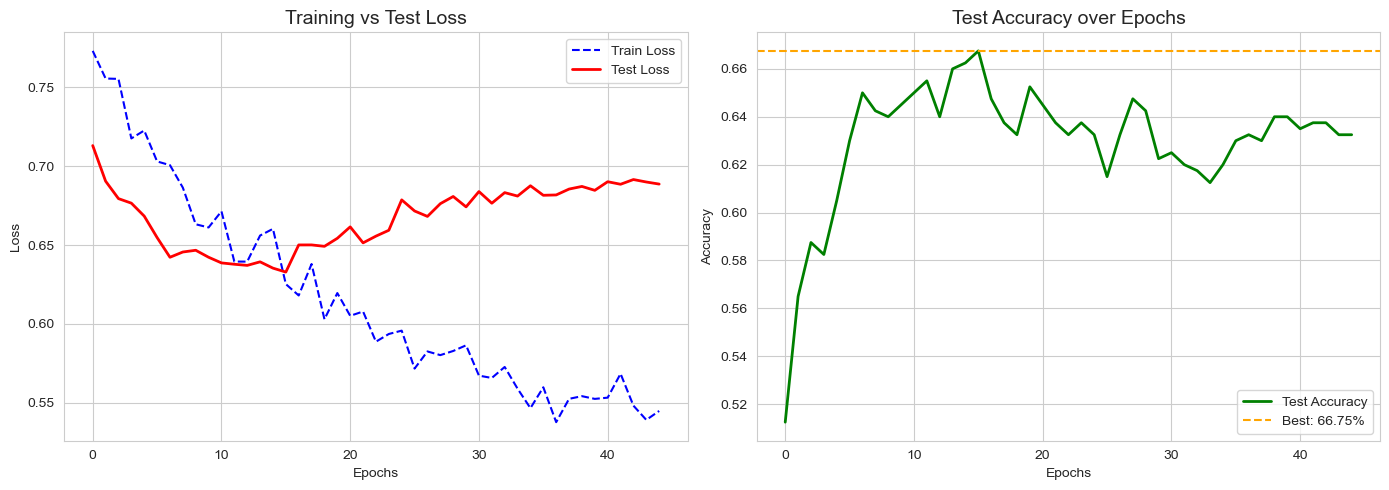


CHI TIẾT ĐÁNH GIÁ (CLASSIFICATION REPORT)
              precision    recall  f1-score   support

    0_AnToan       0.69      0.62      0.65       200
    1_NguyCo       0.65      0.71      0.68       200

    accuracy                           0.67       400
   macro avg       0.67      0.67      0.67       400
weighted avg       0.67      0.67      0.67       400



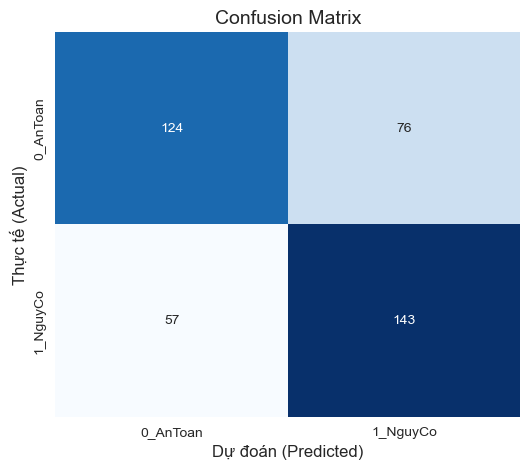

In [14]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, models, transforms
from torch.utils.data import DataLoader, Subset
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import copy

# ==========================================
# 1. CẤU HÌNH FINAL (Lấy từ Trial 1 - Best Result)
# ==========================================
FINAL_LR = 2.50e-04
FINAL_WD = 8.93e-04
FINAL_DROPOUT = 0.52
FINAL_EPOCHS = 45       # Train dư ra một chút để Scheduler chạy hết chu kỳ
UNFREEZE_AT = 5         # Epoch bắt đầu unfreeze
BATCH_SIZE = 32

print(f"🚀 BẮT ĐẦU FINAL TRAIN (Full Data) với cấu hình Trial 1:")
print(f"   - LR: {FINAL_LR}")
print(f"   - Weight Decay: {FINAL_WD}")
print(f"   - Dropout: {FINAL_DROPOUT}")

# ==========================================
# 2. CHUẨN BỊ DỮ LIỆU
# ==========================================
# Gộp tập Train + Val lại để train lần cuối
full_train_data = CustomSubset(train_val_subset, transform=data_transforms['train'])
final_train_loader = DataLoader(full_train_data, batch_size=BATCH_SIZE, shuffle=True, num_workers=0)

# Tập Test giữ nguyên để đánh giá khách quan
final_test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)

# ==========================================
# 3. KHỞI TẠO MODEL & OPTIMIZER
# ==========================================
model = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)
num_ftrs = model.fc.in_features

# Cấu trúc Binary với Dropout của Trial 1
model.fc = nn.Sequential(
    nn.Dropout(p=FINAL_DROPOUT),
    nn.Linear(num_ftrs, 2)
)
model = model.to(device)

# Freeze ban đầu
for param in model.parameters(): param.requires_grad = False
for param in model.fc.parameters(): param.requires_grad = True

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.fc.parameters(), lr=FINAL_LR, weight_decay=FINAL_WD)
scheduler = None # Chưa dùng scheduler đoạn đầu

# ==========================================
# 4. TRAINING LOOP
# ==========================================
history = {'train_loss': [], 'test_loss': [], 'test_acc': []}
best_acc = 0.0
best_model_wts = copy.deepcopy(model.state_dict())

for epoch in range(FINAL_EPOCHS):
    # --- UNFREEZE PHASE ---
    if epoch == UNFREEZE_AT:
        print(f"🔓 Unfreeze toàn bộ model tại Epoch {epoch+1}...")
        for param in model.parameters():
            param.requires_grad = True
        
        # Tạo optimizer mới cho toàn bộ model, giảm LR 10 lần như chiến thuật cũ
        optimizer = optim.Adam(model.parameters(), lr=FINAL_LR * 0.1, weight_decay=FINAL_WD)
        
        # Thêm Scheduler (Vì Trial 1 thành công nhờ có Scheduler)
        # T_max là số epoch còn lại
        scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=FINAL_EPOCHS - UNFREEZE_AT)

    # --- TRAIN ---
    model.train()
    running_loss = 0.0
    for inputs, labels in final_train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * inputs.size(0)
    
    # Cập nhật Scheduler (nếu có)
    if scheduler:
        scheduler.step()
        
    epoch_train_loss = running_loss / len(final_train_loader.dataset)

    # --- TEST (EVALUATION) ---
    model.eval()
    running_loss = 0.0
    corrects = 0
    with torch.no_grad():
        for inputs, labels in final_test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            _, preds = torch.max(outputs, 1)
            
            running_loss += loss.item() * inputs.size(0)
            corrects += torch.sum(preds == labels.data)
            
    epoch_test_loss = running_loss / len(final_test_loader.dataset)
    epoch_test_acc = corrects.double() / len(final_test_loader.dataset)
    epoch_test_acc = epoch_test_acc.item()

    # Lưu history
    history['train_loss'].append(epoch_train_loss)
    history['test_loss'].append(epoch_test_loss)
    history['test_acc'].append(epoch_test_acc)

    # Lưu model tốt nhất
    if epoch_test_acc > best_acc:
        best_acc = epoch_test_acc
        best_model_wts = copy.deepcopy(model.state_dict())

    # In log gọn
    print(f"Ep {epoch+1:02d}/{FINAL_EPOCHS}: Train Loss={epoch_train_loss:.3f} | Test Loss={epoch_test_loss:.3f} | Test Acc={epoch_test_acc:.2%}")

print(f"\n🏆 KẾT QUẢ TỐT NHẤT TRÊN TEST SET: {best_acc:.2%}")

# Lưu file model tốt nhất
torch.save(best_model_wts, 'best_model_binary_longan.pth')
print("✅ Đã lưu weights tốt nhất vào: best_model_binary_longan.pth")

# ==========================================
# 5. VẼ BIỂU ĐỒ & ĐÁNH GIÁ (VISUALIZATION)
# ==========================================
sns.set_style("whitegrid")

# Biểu đồ 1: Loss & Accuracy
plt.figure(figsize=(14, 5))

# Subplot Loss
plt.subplot(1, 2, 1)
plt.plot(history['train_loss'], label='Train Loss', color='blue', linestyle='--')
plt.plot(history['test_loss'], label='Test Loss', color='red', linewidth=2)
plt.title('Training vs Test Loss', fontsize=14)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Subplot Accuracy
plt.subplot(1, 2, 2)
plt.plot(history['test_acc'], label='Test Accuracy', color='green', linewidth=2)
plt.axhline(y=max(history['test_acc']), color='orange', linestyle='--', label=f'Best: {best_acc:.2%}')
plt.title('Test Accuracy over Epochs', fontsize=14)
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

# Biểu đồ 2: Confusion Matrix
model.load_state_dict(best_model_wts) # Load lại weight tốt nhất để đánh giá
model.eval()

y_true = []
y_pred = []

with torch.no_grad():
    for inputs, labels in final_test_loader:
        inputs = inputs.to(device)
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(preds.cpu().numpy())

# In Báo cáo
print("\n" + "="*40)
print("CHI TIẾT ĐÁNH GIÁ (CLASSIFICATION REPORT)")
print("="*40)
print(classification_report(y_true, y_pred, target_names=class_names))

# Vẽ Ma trận nhầm lẫn
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=class_names, yticklabels=class_names, cbar=False)
plt.xlabel('Dự đoán (Predicted)', fontsize=12)
plt.ylabel('Thực tế (Actual)', fontsize=12)
plt.title('Confusion Matrix', fontsize=14)
plt.show()